# R1 - Data Exploration and Analysis for Flower Image Similarity

This notebook explores the 102 Flower Category Dataset for an image similarity project. We'll analyze dataset characteristics, class distribution, visual properties, and generate insights to inform the design of image similarity assessment model.

## Project Overview

We're working with a dataset of 102 flower classes commonly found in the UK, with 40-258 images per class. Our goal is to build an image similarity assessment network that can determine whether two flower images belong to the same class.

The dataset has substantial:
- **Intra-class variation**: Images of the same flower class can look quite different
- **Inter-class similarity**: Different flower species can appear visually similar
- **Variations in scale, pose, and lighting**: Creating challenges for model performance

Let's begin by setting up our environment and exploring the dataset.

## Section 1: Environment Setup

First, we'll install the necessary packages required for our data exploration.

In [1]:
# Install required packages
!pip install torch torchvision matplotlib seaborn scikit-learn scipy timm pandas

In [2]:
# Import necessary libraries
import os
import glob
import time
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models

# Optional: import timm for exploring pretrained models
import timm

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_theme(style="whitegrid")

# Enable inline plotting
%matplotlib inline

In [3]:
# Set global seeds for reproducibility
def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds(42)

# Set global configuration
CONFIG = {
    'data_dir': 'dataset',
    'random_seed': 42,
    'image_size': 224,
    'batch_size': 32,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
}

print(f"Using device: {CONFIG['device']}")

Using device: cpu


## Section 2: Dataset Download and Preparation

We'll download the 102 Flowers Dataset from the Oxford Visual Geometry Group website. The dataset consists of:

1. `102flowers.tgz`: Contains the flower images
2. `imagelabels.mat`: Contains the class labels for each image
3. `setid.mat`: Contains predefined train, validation, and test splits

Let's download and extract these files.

In [4]:
# Check if the dataset files already exist, and download them if they don't
if not os.path.exists('102flowers.tgz'):
    print("Downloading 102flowers.tgz...")
    !wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
else:
    print("102flowers.tgz already exists")

if not os.path.exists('imagelabels.mat'):
    print("Downloading imagelabels.mat...")
    !wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
else:
    print("imagelabels.mat already exists")

if not os.path.exists('setid.mat'):
    print("Downloading setid.mat...")
    !wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/setid.mat
else:
    print("setid.mat already exists")

102flowers.tgz already exists
--2025-07-18 21:21:29--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/flowers/102/imagelabels.mat [following]
--2025-07-18 21:21:29--  https://thor.robots.ox.ac.uk/flowers/102/imagelabels.mat
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 502 [application/octet-stream]
Saving to: ‘imagelabels.mat’

imagelabels.mat     100%[===================>]     502  --.-KB/s    in 0s      

2025-07-18 21:21:30 (88.9 MB/s) - ‘imagelabels.mat’ saved [502/502]

--2025-07-18 21:21:30--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/s

In [5]:
# Extract the image dataset if it hasn't been extracted yet
if not os.path.exists('jpg'):
    print("Extracting 102flowers.tgz...")
    !tar -xzf 102flowers.tgz
else:
    print("Images already extracted")

Images already extracted


In [6]:
# Helper function to load MAT files with fallback
def load_mat(filepath):
    """Load MAT file with fallback to h5py for newer MAT file formats."""
    try:
        from scipy.io import loadmat
        return loadmat(filepath)
    except:
        import h5py
        with h5py.File(filepath, 'r') as f:
            data = {key: value[:] for key, value in f.items()}
        return data

# Load image labels and dataset split information
image_labels = load_mat("imagelabels.mat")
setid = load_mat("setid.mat")

print("Keys in image_labels:", image_labels.keys())
print("Keys in setid:", setid.keys())

Keys in image_labels: dict_keys(['__header__', '__version__', '__globals__', 'labels'])
Keys in setid: dict_keys(['__header__', '__version__', '__globals__', 'trnid', 'valid', 'tstid'])


In [7]:
# Extract labels and examine their structure
labels = image_labels["labels"]
print(f"Labels shape: {labels.shape}")
print(f"Labels min value: {np.min(labels)}")
print(f"Labels max value: {np.max(labels)}")

# Get the distribution of classes
values, counts = np.unique(labels, return_counts=True)
print("\nClass distribution statistics:")
print(f"Number of classes: {len(values)}")
print(f"Minimum samples per class: {np.min(counts)}")
print(f"Maximum samples per class: {np.max(counts)}")
print(f"Mean samples per class: {np.mean(counts):.2f}")
print(f"Median samples per class: {np.median(counts):.2f}")

# Create a DataFrame to better visualize the class distribution
class_distribution = pd.DataFrame({
    'Class': values,
    'Count': counts
})

class_distribution.head()

Labels shape: (1, 8189)
Labels min value: 1
Labels max value: 102

Class distribution statistics:
Number of classes: 102
Minimum samples per class: 40
Maximum samples per class: 258
Mean samples per class: 80.28
Median samples per class: 66.00


,Class,Count
0,1,40
1,2,60
2,3,40
3,4,56
4,5,65


## Section 3: Class Distribution Analysis

Now that we've loaded the dataset, let's visualize the class distribution to understand if there's any class imbalance.

/tmp/ipython-input-8-1044788452.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class', y='Count', data=class_distribution, palette='viridis')


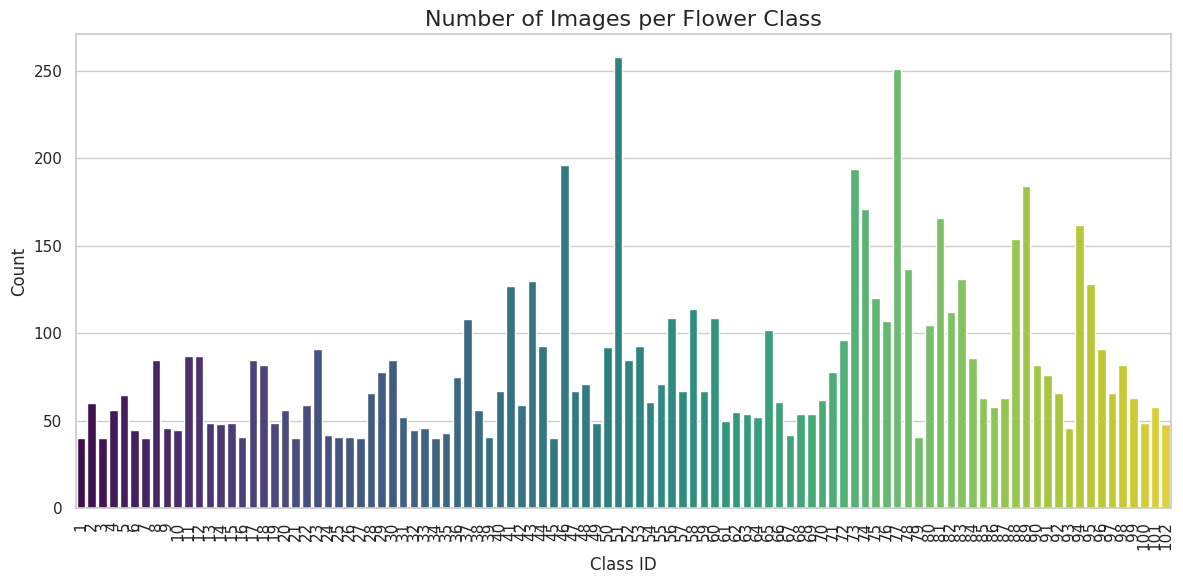

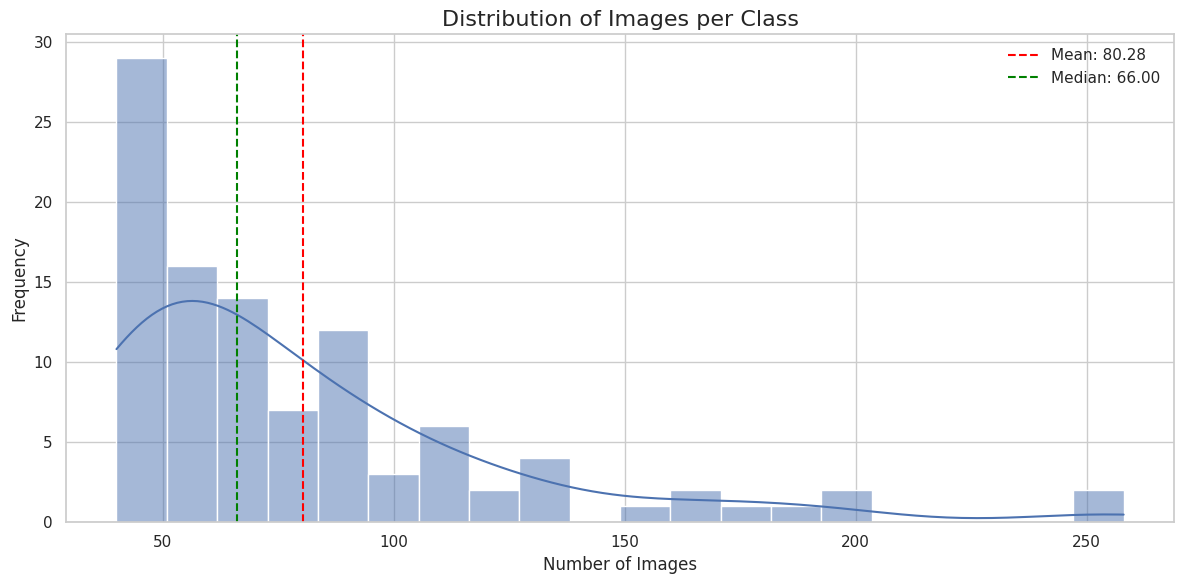

In [8]:
# Visualize class distribution with a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Class', y='Count', data=class_distribution, palette='viridis')
plt.title('Number of Images per Flower Class', fontsize=16)
plt.xlabel('Class ID', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Create a histogram for better visualization of distribution pattern
plt.figure(figsize=(12, 6))
sns.histplot(counts, bins=20, kde=True)
plt.title('Distribution of Images per Class', fontsize=16)
plt.xlabel('Number of Images', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(np.mean(counts), color='red', linestyle='--', label=f'Mean: {np.mean(counts):.2f}')
plt.axvline(np.median(counts), color='green', linestyle='--', label=f'Median: {np.median(counts):.2f}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
# Examine the provided dataset splits
train_ids = setid["tstid"].flatten() if "tstid" in setid else setid["tst"].flatten()
validation_ids = setid["valid"].flatten()
test_ids = setid["trnid"].flatten() if "trnid" in setid else setid["trn"].flatten()

print(f"Train set: {len(train_ids)} images")
print(f"Validation set: {len(validation_ids)} images")
print(f"Test set: {len(test_ids)} images")
print(f"Total: {len(train_ids) + len(validation_ids) + len(test_ids)} images")

# Check for any overlap between sets
train_set = set(train_ids)
val_set = set(validation_ids)
test_set = set(test_ids)

print("\nChecking for overlapping IDs:")
print(f"Train and validation overlap: {len(train_set.intersection(val_set))} images")
print(f"Train and test overlap: {len(train_set.intersection(test_set))} images")
print(f"Validation and test overlap: {len(val_set.intersection(test_set))} images")

Train set: 6149 images
Validation set: 1020 images
Test set: 1020 images
Total: 8189 images

Checking for overlapping IDs:
Train and validation overlap: 0 images
Train and test overlap: 0 images
Validation and test overlap: 0 images


## Section 4: Image Loading and Inspection

Now let's load the actual images and inspect their properties. We'll check for:
- Image dimensions and formats
- Corrupted or missing files
- Visual characteristics of the dataset

In [10]:
# Get list of all image files
image_dir = Path('jpg')
image_paths = sorted(list(image_dir.glob('image_*.jpg')),
                    key=lambda x: int(x.stem.split('_')[1]))

print(f"Total number of image files found: {len(image_paths)}")
print(f"First few image filenames: {[path.name for path in image_paths[:5]]}")

# Associate images with their labels
image_info = []
missing_ids = []

for img_path in image_paths:
    img_id = int(img_path.stem.split('_')[1])

    if img_id > len(labels[0]):
        missing_ids.append(img_id)
        continue

    label = labels[0, img_id-1]  # -1 because indices are 1-based in the dataset

    # Check which set this image belongs to
    if img_id in train_ids:
        dataset_split = 'train'
    elif img_id in validation_ids:
        dataset_split = 'validation'
    elif img_id in test_ids:
        dataset_split = 'test'
    else:
        dataset_split = 'unknown'

    image_info.append({
        'image_id': img_id,
        'path': img_path,
        'label': int(label),
        'split': dataset_split
    })

# Convert to DataFrame for easier analysis
image_df = pd.DataFrame(image_info)
print("\nImage dataframe summary:")
print(image_df.head())

# Check for any issues
if missing_ids:
    print(f"\nWarning: {len(missing_ids)} images don't have corresponding labels")
    print(f"Missing IDs: {missing_ids[:10]}...")

print("\nSplit distribution in the dataset:")
print(image_df['split'].value_counts())

Total number of image files found: 375
First few image filenames: ['image_00009.jpg', 'image_00022.jpg', 'image_00030.jpg', 'image_00032.jpg', 'image_00094.jpg']

Image dataframe summary:
   image_id                 path  label       split
0         9  jpg/image_00009.jpg     77       train
1        22  jpg/image_00022.jpg     77       train
2        30  jpg/image_00030.jpg     77       train
3        32  jpg/image_00032.jpg     77       train
4        94  jpg/image_00094.jpg     77  validation

Split distribution in the dataset:
split
train         270
validation     57
test           48
Name: count, dtype: int64


In [11]:
# Analyze image properties (dimensions, file sizes)
def get_image_properties(img_path):
    """Extract basic properties from an image file."""
    try:
        with Image.open(img_path) as img:
            width, height = img.size
            mode = img.mode
            file_size = os.path.getsize(img_path) / 1024  # size in KB
            return {'width': width, 'height': height, 'mode': mode, 'file_size': file_size}
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return {'width': 0, 'height': 0, 'mode': 'error', 'file_size': 0}

# Sample a subset of images to analyze properties (to save time)
sample_size = len(image_df) # min(200, len(image_df))
sample_df = image_df.sample(sample_size, random_state=42)

# Get properties for the sampled images
props = []
for img_path in sample_df['path']:
    props.append(get_image_properties(img_path))

# Add properties to the dataframe
sample_df = pd.concat([sample_df.reset_index(drop=True),
                       pd.DataFrame(props).reset_index(drop=True)], axis=1)

# Display statistics about image properties
print(f"Image Count: {sample_size}")
print("\nImage property statistics:")
print(f"Width - min: {sample_df['width'].min()}, max: {sample_df['width'].max()}, mean: {sample_df['width'].mean():.2f}")
print(f"Height - min: {sample_df['height'].min()}, max: {sample_df['height'].max()}, mean: {sample_df['height'].mean():.2f}")
print(f"File size (KB) - min: {sample_df['file_size'].min():.2f}, max: {sample_df['file_size'].max():.2f}, mean: {sample_df['file_size'].mean():.2f}")
print("\nColor modes:")
print(sample_df['mode'].value_counts())

Image Count: 375

Image property statistics:
Width - min: 500, max: 825, mean: 623.00
Height - min: 500, max: 926, mean: 537.07
File size (KB) - min: 10.00, max: 84.92, mean: 40.44

Color modes:
mode
RGB    375
Name: count, dtype: int64


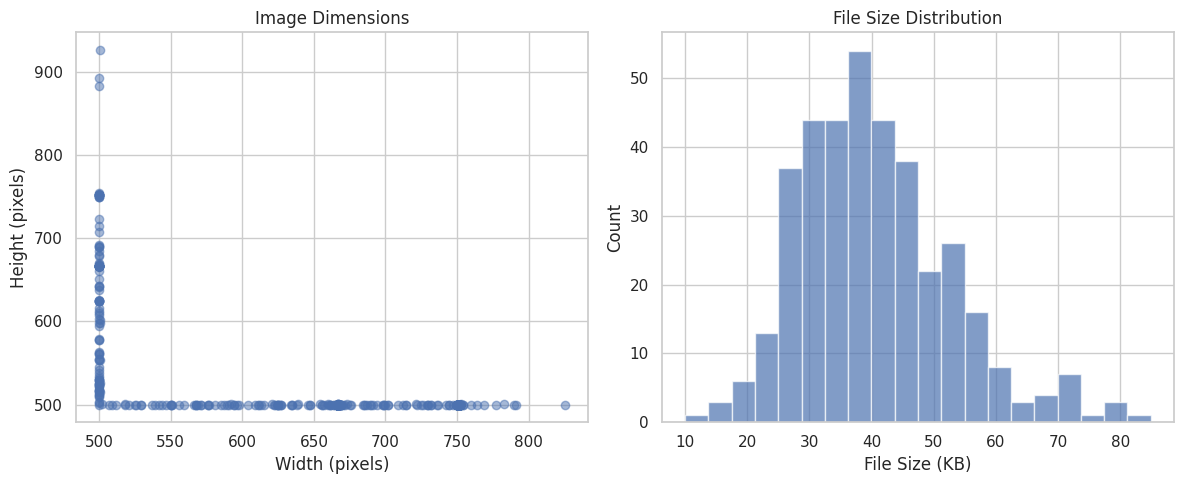

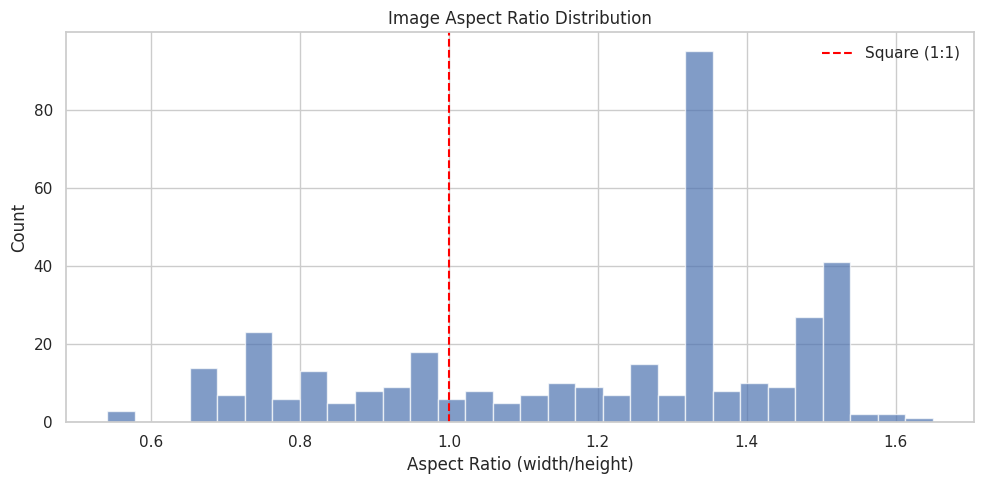

In [12]:
# Visualize image dimensions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(sample_df['width'], sample_df['height'], alpha=0.5)
plt.title('Image Dimensions')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(sample_df['file_size'], bins=20, alpha=0.7)
plt.title('File Size Distribution')
plt.xlabel('File Size (KB)')
plt.ylabel('Count')
plt.grid(True)

plt.tight_layout()
plt.show()

# Check aspect ratios
sample_df['aspect_ratio'] = sample_df['width'] / sample_df['height']

plt.figure(figsize=(10, 5))
plt.hist(sample_df['aspect_ratio'], bins=30, alpha=0.7)
plt.title('Image Aspect Ratio Distribution')
plt.xlabel('Aspect Ratio (width/height)')
plt.ylabel('Count')
plt.axvline(1.0, color='red', linestyle='--', label='Square (1:1)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Section 5: Visual Analysis of Sample Images

Let's visualize sample images from different classes to understand the visual characteristics, intra-class variation, and inter-class similarity in the dataset.

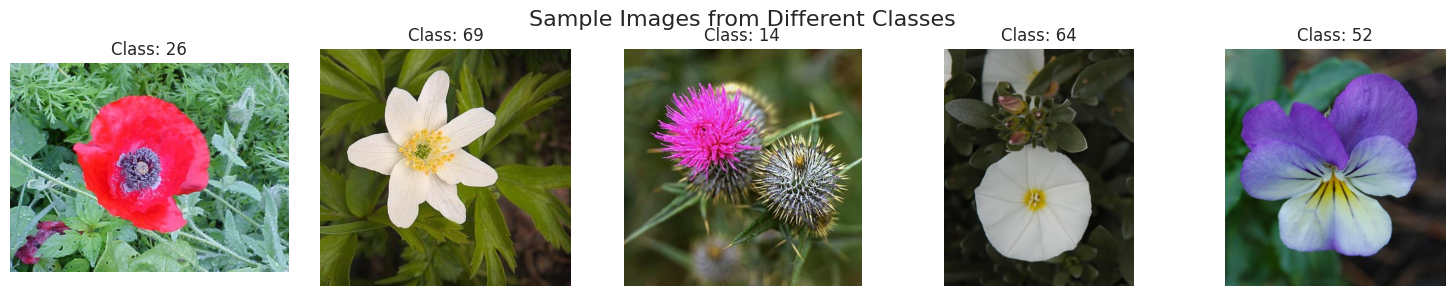

In [13]:
# Function to display sample images from the dataset
def show_sample_images(df, label=None, num_samples=5, figsize=(15, 3)):
    """
    Display sample images from the dataset.

    Args:
        df: DataFrame containing image information
        label: Optional specific class label to display
        num_samples: Number of sample images to display
        figsize: Figure size
    """
    if label is not None:
        # Filter by class label
        subset = df[df['label'] == label]
        title = f"Sample Images from Class {label}"
    else:
        # Get samples from different classes
        unique_labels = df['label'].unique()
        random.shuffle(unique_labels)
        selected_labels = unique_labels[:num_samples]
        subset = pd.concat([df[df['label'] == lbl].sample(1) for lbl in selected_labels])
        title = "Sample Images from Different Classes"

    # Ensure we don't try to display more images than we have
    num_samples = min(num_samples, len(subset))

    # Display the images
    fig, axes = plt.subplots(1, num_samples, figsize=figsize)

    if num_samples == 1:
        axes = [axes]  # Make it iterable for single image case

    for i, (_, row) in enumerate(subset.head(num_samples).iterrows()):
        try:
            img = Image.open(row['path'])
            axes[i].imshow(img)
            axes[i].set_title(f"Class: {row['label']}")
            axes[i].axis('off')
        except Exception as e:
            print(f"Error displaying image {row['path']}: {e}")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

# Display random samples from different classes
show_sample_images(image_df, num_samples=5)

Displaying intra-class variation for class 89:


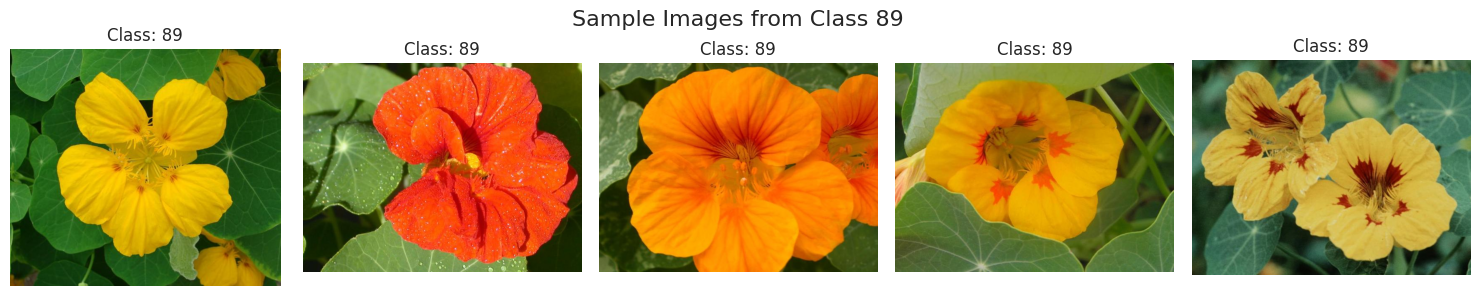

In [14]:
# Get a random class that has sufficient samples
class_counts = image_df['label'].value_counts()
classes_with_many_samples = class_counts[class_counts > 10].index.tolist()
random_class = random.choice(classes_with_many_samples)

# Display multiple samples from the same class to observe intra-class variation
print(f"Displaying intra-class variation for class {random_class}:")
subset_df = image_df[image_df['label'] == random_class]
show_sample_images(subset_df, label=random_class, num_samples=5)

Displaying potentially similar classes for comparison:


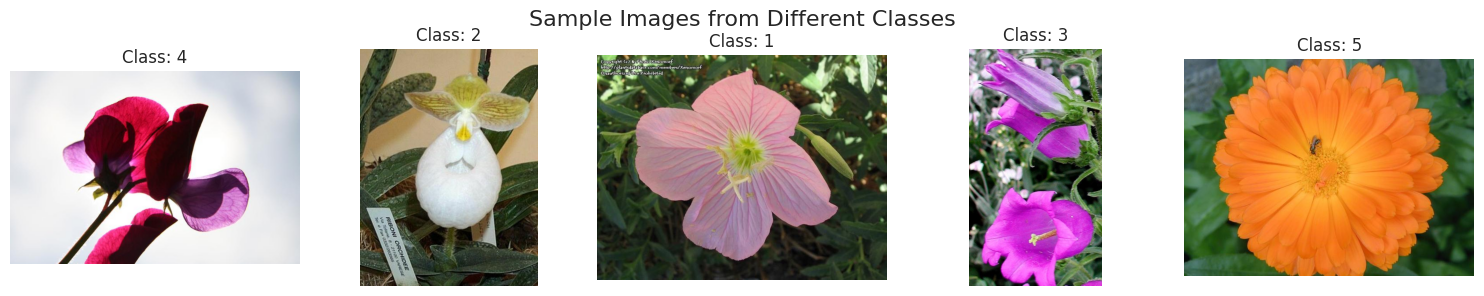

In [15]:
# Display visually similar classes (just a demonstration, actual similarity would be computed)
# For now, we'll just pick a few sequential classes as an example
print("Displaying potentially similar classes for comparison:")
similar_classes = list(range(1, 6))  # Example: classes 1-5 might be similar
similar_df = pd.concat([image_df[image_df['label'] == cls].sample(1) for cls in similar_classes if sum(image_df['label'] == cls) > 0])
show_sample_images(similar_df, num_samples=len(similar_df))

## Section 6: Feature-Based Analysis

To understand the dataset more deeply and identify potential challenges for our model, let's extract some basic features from the images and analyze their distribution. We'll use:

1. Color histograms to capture color distributions
2. Basic image statistics (brightness, contrast) to understand image quality
3. Simple embeddings for dimensionality reduction and visualization

In [16]:
# Function to compute basic features from images
def compute_image_features(img_path):
    """
    Compute basic features from an image.

    Returns:
        dict: Feature dictionary with color histograms and statistics
    """
    try:
        img = Image.open(img_path).convert('RGB')
        img_np = np.array(img)

        # Resize for consistency
        img_small = img.resize((100, 100))
        img_small_np = np.array(img_small)

        # Simple color statistics
        mean_rgb = img_np.mean(axis=(0, 1))
        std_rgb = img_np.std(axis=(0, 1))

        # Brightness and contrast
        grayscale = np.mean(img_np, axis=2)
        brightness = np.mean(grayscale)
        contrast = np.std(grayscale)

        # Simple color histogram (simplified)
        hist_r, _ = np.histogram(img_np[:,:,0], bins=8, range=(0, 256))
        hist_g, _ = np.histogram(img_np[:,:,1], bins=8, range=(0, 256))
        hist_b, _ = np.histogram(img_np[:,:,2], bins=8, range=(0, 256))

        # Normalize histograms
        hist_r = hist_r / hist_r.sum()
        hist_g = hist_g / hist_g.sum()
        hist_b = hist_b / hist_b.sum()

        # Flatten the small image for a simple "embedding"
        flattened = img_small_np.flatten() / 255.0

        return {
            'mean_r': mean_rgb[0],
            'mean_g': mean_rgb[1],
            'mean_b': mean_rgb[2],
            'std_r': std_rgb[0],
            'std_g': std_rgb[1],
            'std_b': std_rgb[2],
            'brightness': brightness,
            'contrast': contrast,
            'hist_r': hist_r,
            'hist_g': hist_g,
            'hist_b': hist_b,
            'flattened': flattened
        }
    except Exception as e:
        print(f"Error extracting features from {img_path}: {e}")
        return None

# Sample a limited number of images for feature extraction (to save time)
max_samples = 30  # Limit samples per class for efficiency
feature_samples = []

# Get balanced samples from each class
for label in sorted(image_df['label'].unique()):
    class_images = image_df[image_df['label'] == label].head(max_samples)
    feature_samples.append(class_images)

feature_df = pd.concat(feature_samples).reset_index(drop=True)
print(f"Selected {len(feature_df)} images for feature analysis")

# Extract features from sampled images
features_list = []
for idx, row in feature_df.iterrows():
    if idx % 20 == 0:
        print(f"Processing image {idx}/{len(feature_df)}...")

    features = compute_image_features(row['path'])
    if features:
        features['label'] = row['label']
        features_list.append(features)

print(f"Successfully extracted features from {len(features_list)} images")

Selected 375 images for feature analysis
Processing image 0/375...
Processing image 20/375...
Processing image 40/375...
Processing image 60/375...
Processing image 80/375...
Processing image 100/375...
Error extracting features from jpg/image_01555.jpg: image file is truncated (13 bytes not processed)
Processing image 120/375...
Processing image 140/375...
Processing image 160/375...
Processing image 180/375...
Processing image 200/375...
Processing image 220/375...
Processing image 240/375...
Processing image 260/375...
Processing image 280/375...
Processing image 300/375...
Processing image 320/375...
Processing image 340/375...
Processing image 360/375...
Successfully extracted features from 374 images


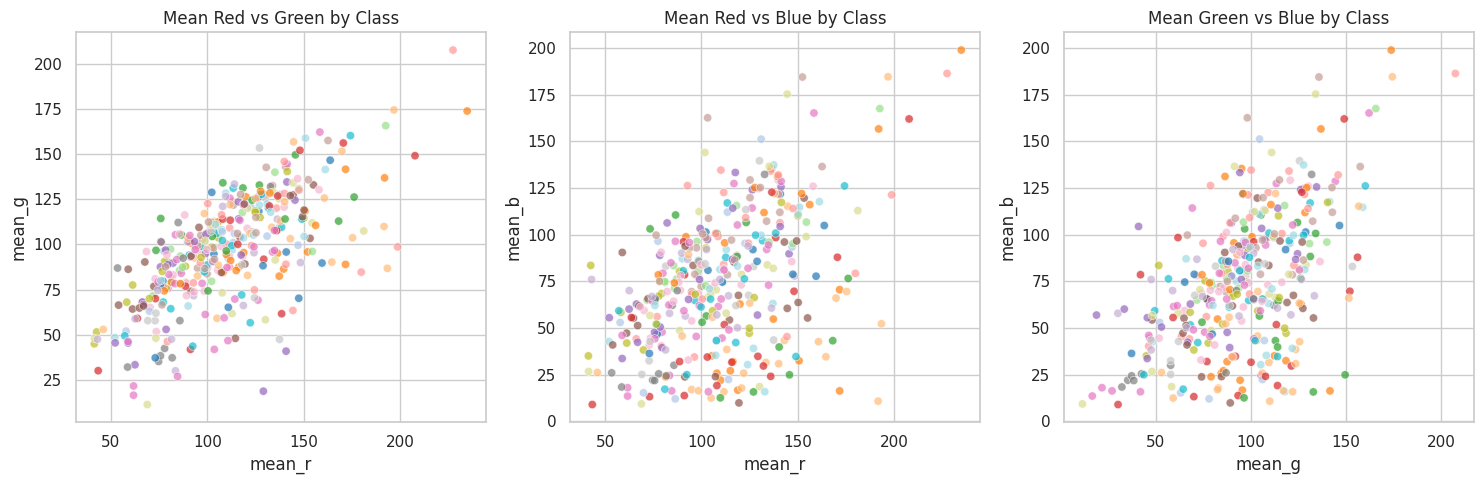

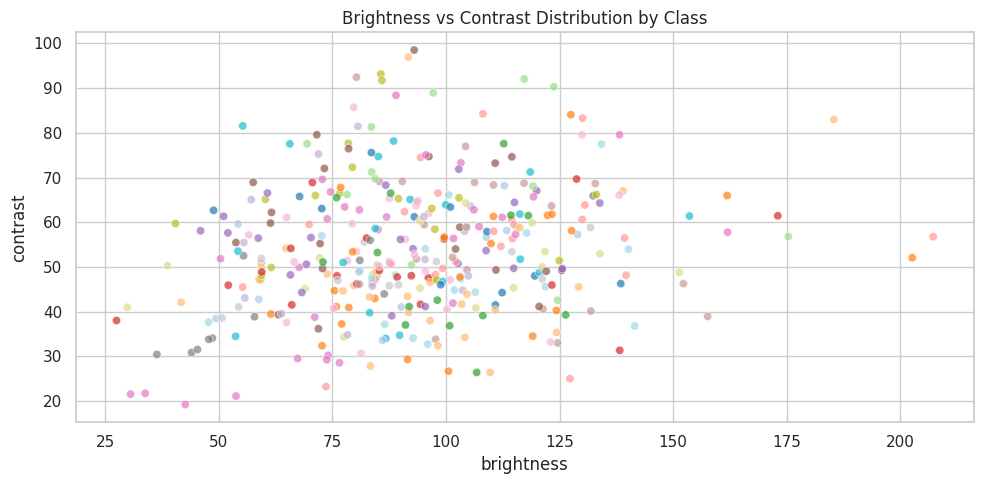

In [17]:
# Convert features to DataFrame for analysis
features_simple = [{k: v for k, v in f.items() if k != 'flattened' and
                   not k.startswith('hist_')} for f in features_list]
features_df = pd.DataFrame(features_simple)

# Visualize color distributions
plt.figure(figsize=(15, 5))

plt.subplot(131)
sns.scatterplot(data=features_df, x='mean_r', y='mean_g', hue='label',
                palette='tab20', legend=False, alpha=0.7)
plt.title('Mean Red vs Green by Class')
plt.grid(True)

plt.subplot(132)
sns.scatterplot(data=features_df, x='mean_r', y='mean_b', hue='label',
                palette='tab20', legend=False, alpha=0.7)
plt.title('Mean Red vs Blue by Class')
plt.grid(True)

plt.subplot(133)
sns.scatterplot(data=features_df, x='mean_g', y='mean_b', hue='label',
                palette='tab20', legend=False, alpha=0.7)
plt.title('Mean Green vs Blue by Class')
plt.grid(True)

plt.tight_layout()
plt.show()

# Analyze brightness and contrast
plt.figure(figsize=(10, 5))
sns.scatterplot(data=features_df, x='brightness', y='contrast', hue='label',
                palette='tab20', legend=False, alpha=0.7)
plt.title('Brightness vs Contrast Distribution by Class')
plt.grid(True)
plt.tight_layout()
plt.show()

Flattened feature shape: (374, 30000)
PCA result shape: (374, 100)
Explained variance ratio: 0.84
t-SNE result shape: (374, 2)


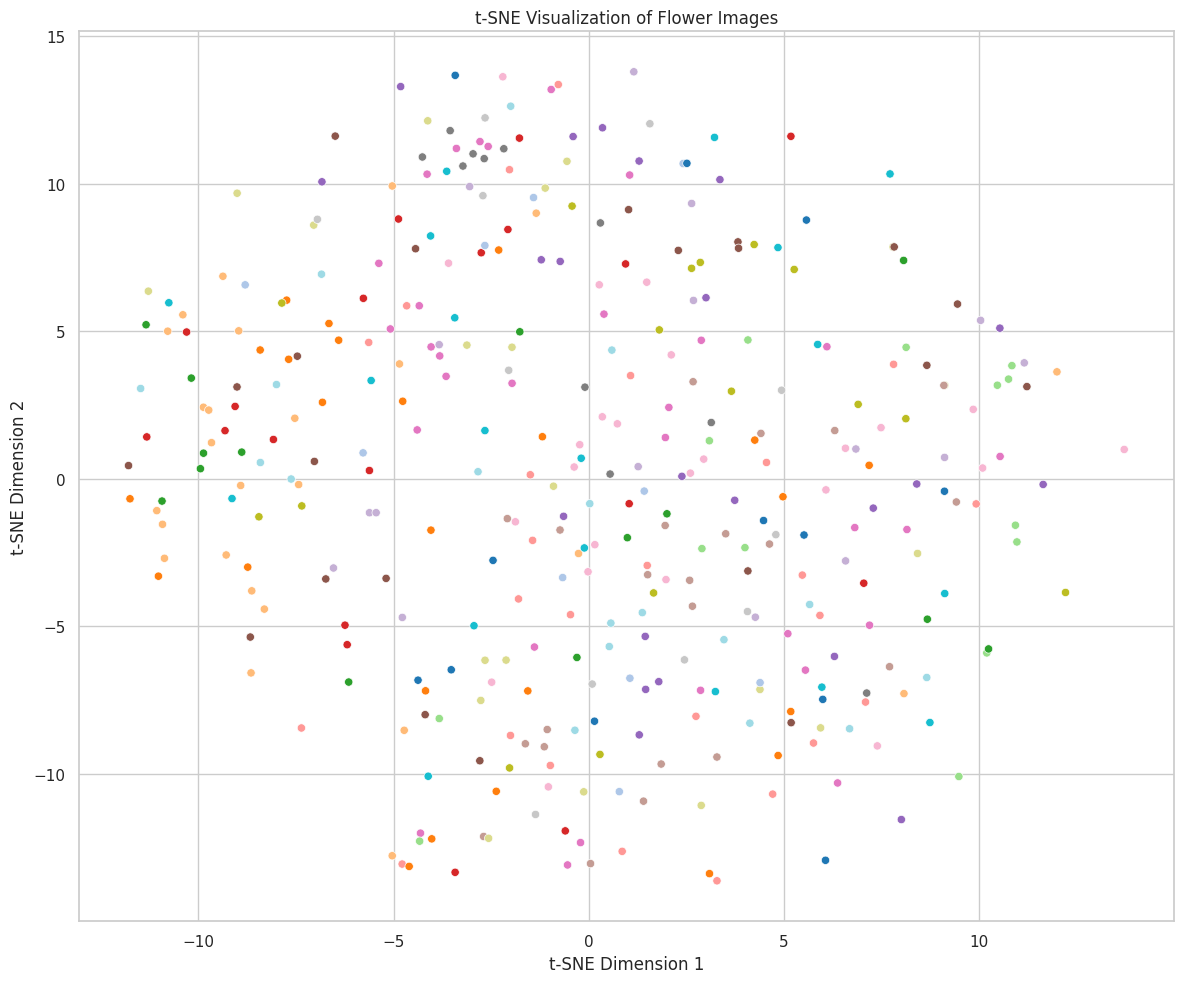

In [18]:
# Extract flattened image data for dimensionality reduction
flattened_features = np.array([f['flattened'] for f in features_list])
labels = np.array([f['label'] for f in features_list])

print(f"Flattened feature shape: {flattened_features.shape}")

# Apply PCA for initial dimensionality reduction
pca = PCA(n_components=100)
pca_result = pca.fit_transform(flattened_features)
print(f"PCA result shape: {pca_result.shape}")
print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_):.2f}")

# Apply t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(pca_result)
print(f"t-SNE result shape: {tsne_result.shape}")

# Create DataFrame for plotting
tsne_df = pd.DataFrame({
    'x': tsne_result[:, 0],
    'y': tsne_result[:, 1],
    'label': labels
})

# Plot t-SNE visualization
plt.figure(figsize=(12, 10))
sns.scatterplot(data=tsne_df, x='x', y='y', hue='label', palette='tab20', legend=False)
plt.title('t-SNE Visualization of Flower Images')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.tight_layout()
plt.grid(True)
plt.show()

## Section 7: Insights for Image Similarity Assessment Model Design

Based on our data exploration, we can derive several insights that will inform the design of our model:

In [19]:
# Summarize dataset statistics
print("Dataset Summary:")
print(f"- Total number of images: {len(image_df)}")
print(f"- Number of classes: {len(image_df['label'].unique())}")
print(f"- Images per class: Min {image_df['label'].value_counts().min()}, Max {image_df['label'].value_counts().max()}, Mean {image_df['label'].value_counts().mean():.2f}")
print(f"- Dataset splits: Train {len(train_ids)}, Validation {len(validation_ids)}, Test {len(test_ids)}")

# Calculate class imbalance metric
imbalance_ratio = image_df['label'].value_counts().max() / image_df['label'].value_counts().min()
print(f"- Class imbalance ratio (max/min): {imbalance_ratio:.2f}")

Dataset Summary:
- Total number of images: 375
- Number of classes: 94
- Images per class: Min 1, Max 14, Mean 3.99
- Dataset splits: Train 6149, Validation 1020, Test 1020
- Class imbalance ratio (max/min): 14.00


1. **Image Preprocessing**: Images have varying dimensions and aspect ratios, requiring resizing and potentially cropping for model input.

2. **Class Distribution**: The dataset has some class imbalance which should be considered during pair generation.

3. **Intra-class Variation**: Substantial variation within classes (lighting, angle, background) suggests the need for robust features.

4. **Inter-class Similarity**: Some flower classes appear visually similar, presenting a challenge for the similarity model.

5. **Data Augmentation**: Given the limited samples per class, data augmentation will be crucial.

6. **Feature Extraction**: Color features visually show some class separation, suggesting a backbone that preserves color information well.

7. **Backbone Selection**: A pre-trained model with good color and texture recognition capabilities would be suitable.

8. **Balanced Pair Generation**: Should ensure equal representation of all classes during pair generation.

9. **Loss Function**: Should penalize misclassifications of visually similar examples more heavily.

## Section 8: Data Export and Next Steps

Finally, let's organize our dataset for the next stage of the project and prepare the necessary metadata for future notebooks.

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
# Create output directories for organized dataset
dataset_dir = Path('.')

# Create metadata for future notebooks
metadata = {
    'dataset_stats': {
        'total_images': len(image_df),
        'num_classes': len(image_df['label'].unique()),
        'class_min_samples': int(image_df['label'].value_counts().min()),
        'class_max_samples': int(image_df['label'].value_counts().max()),
        'class_mean_samples': float(image_df['label'].value_counts().mean()),
        'class_imbalance_ratio': float(imbalance_ratio)
    },
    'splits': {
        'train': len(train_ids),
        'validation': len(validation_ids),
        'test': len(test_ids)
    },
    'image_properties': {
        'width_mean': float(sample_df['width'].mean()),
        'height_mean': float(sample_df['height'].mean()),
        'aspect_ratio_mean': float(sample_df['aspect_ratio'].mean()),
        'color_mode': sample_df['mode'].value_counts().index[0]
    },
    'recommended_preprocessing': {
        'target_size': (224, 224),
        'normalization': 'ImageNet',
        'augmentations': [
            'random_rotation',
            'random_flip',
            'random_brightness',
            'random_contrast',
            'random_saturation'
        ]
    },
    'class_ids': {str(cls): int(cls) for cls in sorted(image_df['label'].unique())}
}

# Save metadata to JSON
import json
with open(dataset_dir / 'metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"Metadata saved to {dataset_dir / 'metadata.json'}")

# Export image paths for next notebook
image_df.to_csv(dataset_dir / 'image_paths.csv', index=False)
print(f"Image paths saved to {dataset_dir / 'image_paths.csv'}")


Metadata saved to metadata.json
Image paths saved to image_paths.csv


In [23]:
!cp -r metadata.json /content/drive/MyDrive/Roshan/
!cp -r image_paths.csv /content/drive/MyDrive/Roshan/
!cp -r jpg /content/drive/MyDrive/Roshan/
!cp -r imagelabels.mat /content/drive/MyDrive/Roshan/
!cp -r setid.mat /content/drive/MyDrive/Roshan/

## Conclusion and Next Steps

In this notebook, we explored the 102 Flowers Dataset and gained valuable insights for our model design:

1. **Dataset Characteristics**:
   - 102 flower classes with varying number of samples per class
   - Substantial intra-class variation and inter-class similarity
   - Predefined train/validation/test splits

2. **Key Findings**:
   - Varying image dimensions and aspect ratios
   - Class imbalance that needs to be addressed
   - Color features show some class separation
   - t-SNE visualization reveals complex clustering structure

3. **Implications for Model**:
   - Need for careful preprocessing and augmentation
   - Balanced pair generation strategy
   - Backbone selection with good color and texture feature extraction
   - Potential benefit from hard negative mining

In the next notebook, we will focus on:
- Implementing the data preparation pipeline
- Developing a dynamic pair generation strategy
- Creating augmentation pipelines for training
- Preparing the dataloader for model training